In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import gluon, image, init, nd
from mxnet.gluon import data as gdata, loss as gloss, model_zoo, nn
import numpy as np
import sys

In [2]:
X = nd.arange(1, 17).reshape((1, 1, 4, 4))
K = nd.arange(1, 10).reshape((1, 1, 3, 3))
conv = nn.Conv2D(channels=1, kernel_size=3)
conv.initialize(init.Constant(K))
conv(X), K

(
 [[[[348. 393.]
    [528. 573.]]]]
 <NDArray 1x1x2x2 @cpu(0)>,
 
 [[[[1. 2. 3.]
    [4. 5. 6.]
    [7. 8. 9.]]]]
 <NDArray 1x1x3x3 @cpu(0)>)

In [3]:
W, k = nd.zeros((4, 16)), nd.zeros(11)
k[:3], k[4:7], k[8:] = K[0, 0, 0, :], K[0, 0, 1, :], K[0, 0, 2, :]
k


[1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9.]
<NDArray 11 @cpu(0)>

In [4]:
W[0, 0:11], W[1, 1:12], W[2, 4:15], W[3, 5:16] = k, k, k, k
nd.dot(W, X.reshape(16)).reshape((1, 1, 2, 2)), W

(
 [[[[348. 393.]
    [528. 573.]]]]
 <NDArray 1x1x2x2 @cpu(0)>,
 
 [[1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9. 0. 0. 0. 0. 0.]
  [0. 1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9. 0.]
  [0. 0. 0. 0. 0. 1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9.]]
 <NDArray 4x16 @cpu(0)>)

In [5]:
conv = nn.Conv2D(10, kernel_size=4, padding=1, strides=2)
conv.initialize()

X = nd.random.uniform(shape=(1, 3, 64, 64))
X
Y = conv(X)
Y.shape

(1, 10, 32, 32)

In [6]:
conv_trans = nn.Conv2DTranspose(3, kernel_size=4, padding=1, strides=2)
conv_trans.initialize()
conv_trans(Y).shape

(1, 3, 64, 64)

In [7]:
# 加载预训练模型
pretrained_net = model_zoo.vision.resnet18_v2(pretrained=True)
pretrained_net.features[-4:], pretrained_net.output

(HybridSequential(
   (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=512)
   (1): Activation(relu)
   (2): GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True, global_pool=True, pool_type=avg, layout=NCHW)
   (3): Flatten
 ),
 Dense(512 -> 1000, linear))

In [8]:
net = nn.HybridSequential()
for layer in pretrained_net.features[:-2]:
    net.add(layer)

In [9]:
X = nd.random.uniform(shape=(1, 3, 320, 480))
net(X).shape

(1, 512, 10, 15)

In [10]:
num_classes = 21
# ，如果步幅为 s 、填充为 s/2 （假设 s/2 为整数）、
# 卷积核的高和宽为 2s ，转置卷积核将输入的高和宽分别放大 s 倍。
net.add(nn.Conv2D(num_classes, kernel_size=1),
        nn.Conv2DTranspose(num_classes, kernel_size=64, padding=16,
                           strides=32))

In [11]:
# 上采样，双线性插值的方法
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return nd.array(weight)

In [12]:
conv_trans = nn.Conv2DTranspose(3, kernel_size=4, padding=1, strides=2)
conv_trans.initialize(init.Constant(bilinear_kernel(3, 3, 4)))

In [13]:
img = image.imread('../img/catdog.jpg')
X = img.astype('float32').transpose((2, 0, 1)).expand_dims(axis=0) / 255
Y = conv_trans(X)
out_img = Y[0].transpose((1, 2, 0))

input image shape: (561, 728, 3)


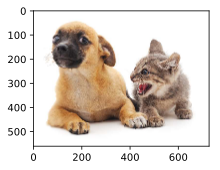

In [14]:
d2l.set_figsize()
print('input image shape:', img.shape)
d2l.plt.imshow(img.asnumpy());

output image shape: (1122, 1456, 3)


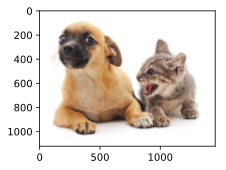

In [15]:
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img.asnumpy());

In [16]:
net[-1].initialize(init.Constant(bilinear_kernel(num_classes, num_classes, 64)),force_reinit=True)
net[-2].initialize(init=init.Xavier(),force_reinit=True)

In [17]:
crop_size, batch_size, colormap2label = (320, 480), 32, nd.zeros(256**3)
for i, cm in enumerate(d2l.VOC_COLORMAP):
    colormap2label[(cm[0] * 256 + cm[1]) * 256 + cm[2]] = i
voc_dir = d2l.download_voc_pascal(data_dir='../data')

num_workers = 0 if sys.platform.startswith('win32') else 4
train_iter = gdata.DataLoader(
    d2l.VOCSegDataset(True, crop_size, voc_dir, colormap2label), batch_size,
    shuffle=True, last_batch='discard', num_workers=num_workers)
test_iter = gdata.DataLoader(
    d2l.VOCSegDataset(False, crop_size, voc_dir, colormap2label), batch_size,
    last_batch='discard', num_workers=num_workers)

read 1114 examples
read 1078 examples


In [20]:
ctx = d2l.try_all_gpus()
loss = gloss.SoftmaxCrossEntropyLoss(axis=1)
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.15,
                                                      'wd': 1e-3})
d2l.train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs=5)

training on [gpu(0)]
epoch 1, loss 1.3750, train acc 0.724, test acc 0.714, time 79.4 sec
epoch 2, loss 1.3166, train acc 0.727, test acc 0.723, time 79.7 sec
epoch 3, loss 1.2866, train acc 0.727, test acc 0.728, time 77.7 sec
epoch 4, loss 1.2739, train acc 0.728, test acc 0.728, time 77.5 sec
epoch 5, loss 1.2707, train acc 0.727, test acc 0.729, time 77.5 sec


In [21]:
def predict(img):
    X = test_iter._dataset.normalize_image(img)
    X = X.transpose((2, 0, 1)).expand_dims(axis=0)
    pred = nd.argmax(net(X.as_in_context(ctx[0])), axis=1)
    return pred.reshape((pred.shape[1], pred.shape[2]))

In [22]:
def label2image(pred):
    colormap = nd.array(d2l.VOC_COLORMAP, ctx=ctx[0], dtype='uint8')
    X = pred.astype('int32')
    return colormap[X, :]

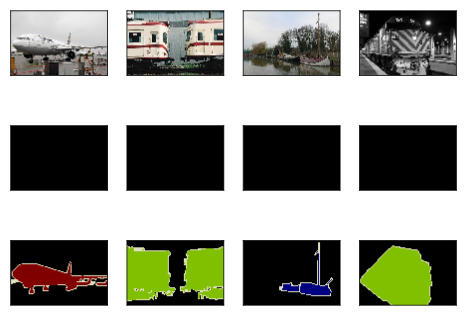

In [23]:
test_images, test_labels = d2l.read_voc_images(is_train=False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 480, 320)
    X = image.fixed_crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X, pred, image.fixed_crop(test_labels[i], *crop_rect)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n);

In [24]:
X = nd.arange(1, 17).reshape((2, 2, 4))

In [25]:
X


[[[ 1.  2.  3.  4.]
  [ 5.  6.  7.  8.]]

 [[ 9. 10. 11. 12.]
  [13. 14. 15. 16.]]]
<NDArray 2x2x4 @cpu(0)>

In [33]:
X[::2]


[[[1. 2. 3. 4.]
  [5. 6. 7. 8.]]]
<NDArray 1x2x4 @cpu(0)>

In [31]:
X[1::1]


[[[ 9. 10. 11. 12.]
  [13. 14. 15. 16.]]]
<NDArray 1x2x4 @cpu(0)>

In [30]:
X[:1]


[[[1. 2. 3. 4.]
  [5. 6. 7. 8.]]]
<NDArray 1x2x4 @cpu(0)>